In [75]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import roc_curve, auc
import random
import numpy as np

from collections import Counter


# 1. Chargement et préparation des ensembles de données : MVTec AD et AutoVI

In [80]:
# DATA AUGMENTATION (DONE !!!!!!)
"""
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm  # Pour afficher une barre de progression

# Dossier contenant les images "good" pour l'entraînement
source_dir = "AutoVI/engine_wiring/train/good"
output_dir = "AutoVI/engine_wiring_augmented/train/good"

# Transformation pour data augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

# Créer le dossier de sortie s'il n'existe pas
os.makedirs(output_dir, exist_ok=True)

# Nombre d'augmentations par image
augmentations_per_image = 5

# Appliquer la data augmentation hors-ligne
for img_name in tqdm(os.listdir(source_dir)):
    img_path = os.path.join(source_dir, img_name)
    img = Image.open(img_path)

    for i in range(augmentations_per_image):
        augmented_img = augmentation_transform(img)
        augmented_img.save(os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i}.png"))

print(f"Augmentation terminée. Les images sont enregistrées dans {output_dir}")
"""

100%|█████████████████████████████████████████| 285/285 [00:14<00:00, 19.87it/s]

Augmentation terminée. Les images sont enregistrées dans AutoVI/engine_wiring_augmented/train/good


## 1- AutoVI

In [81]:
# Chemins des dossiers pour AutoVI
autovi_train_dir = "AutoVI/engine_wiring_augmented/train"
autovi_test_dir = "AutoVI/engine_wiring/test"

"""
# Transformation avec data augmentation pour le dataset d'entraînement                 ( PAS une vraie data augmentattion --> voir chatgpt )
autovi_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontal aléatoire
    transforms.RandomRotation(degrees=15),  # Rotation aléatoire jusqu'à 15°
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),  # Crop aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Modification des couleurs
    transforms.ToTensor(),  # Convertit en tenseurs
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
])
"""
# Transformation standard pour le test (sans augmentation)
autovi_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Transformation standard pour le test (sans augmentation)
autovi_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Chargement du dataset d'entraînement avec augmentation
autovi_train_dataset = datasets.ImageFolder(
    root=autovi_train_dir,
    transform=autovi_train_transform
)

# Chargement du dataset de test (sans augmentation)
autovi_test_dataset = datasets.ImageFolder(
    root=autovi_test_dir,
    transform=autovi_test_transform
)

# Création des DataLoaders pour AutoVI
autovi_train_loader = DataLoader(autovi_train_dataset, batch_size=16, shuffle=True)
autovi_test_loader = DataLoader(autovi_test_dataset, batch_size=16, shuffle=False)

# Vérification des classes chargées pour AutoVI
print(f"Classes dans le train (AutoVI) : {autovi_train_dataset.classes}")
print(f"Classes dans le test (AutoVI) : {autovi_test_dataset.classes}")



Classes dans le train (AutoVI) : ['good']
Classes dans le test (AutoVI) : ['blue_hoop', 'cardboard', 'fastening', 'good', 'multiple', 'obstruction']


Nombre d'images dans le train (AutoVI) : 1425
Nombre d'images dans le test (AutoVI) : 607


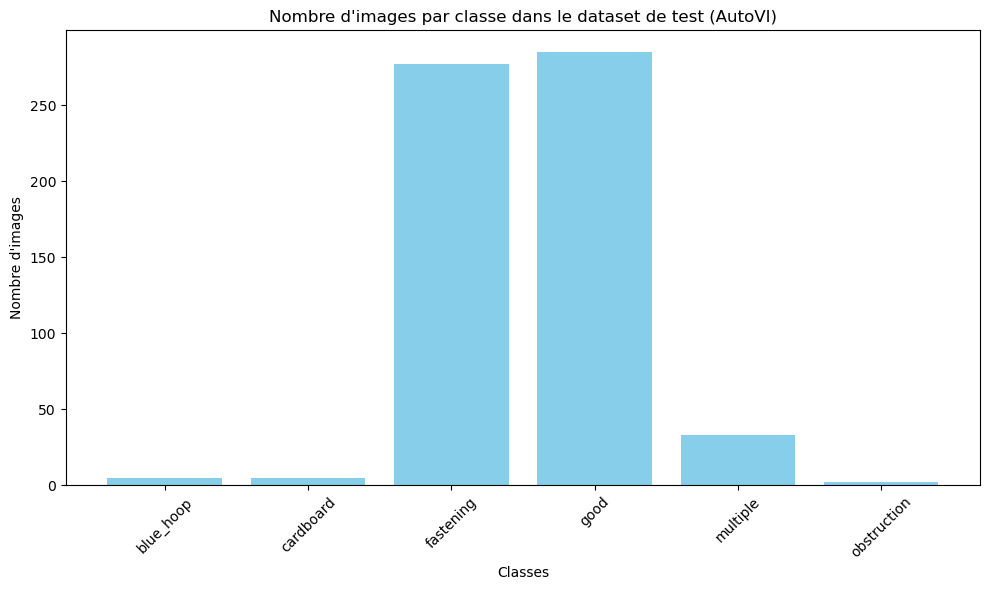

In [82]:

# Nombre total d'images dans le train et le test
num_train_images = len(autovi_train_dataset)
num_test_images = len(autovi_test_dataset)

print(f"Nombre d'images dans le train (AutoVI) : {num_train_images}")
print(f"Nombre d'images dans le test (AutoVI) : {num_test_images}")

# Comptage des images par classe dans le dataset de test
class_counts = Counter([label for _, label in autovi_test_dataset])
class_names = autovi_test_dataset.classes
class_image_counts = {class_names[class_id]: count for class_id, count in class_counts.items()}

# Création du barplot
plt.figure(figsize=(10, 6))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe dans le dataset de test (AutoVI)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


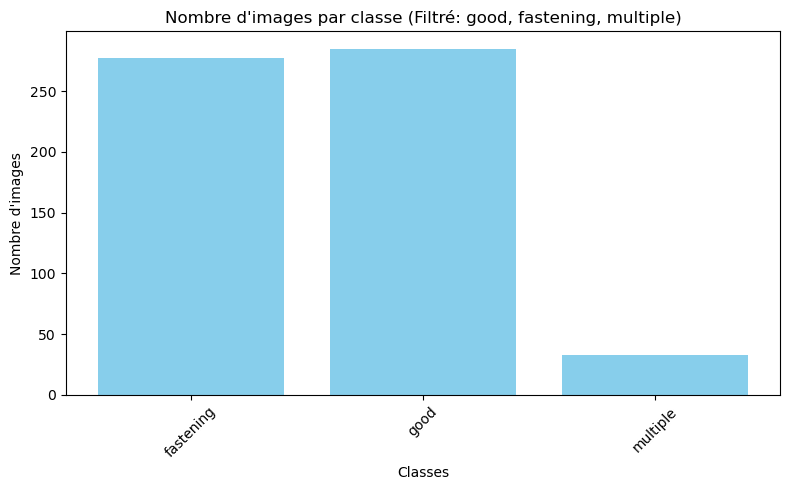

In [83]:
# Classes à conserver
allowed_classes = ["good", "fastening", "multiple"]

# Filtrage des indices des classes correspondantes
allowed_class_indices = [autovi_test_dataset.classes.index(cls) for cls in allowed_classes]

# Création d'un dataset filtré
filtered_test_indices = [
    idx for idx, (_, label) in enumerate(autovi_test_dataset) if label in allowed_class_indices
]

autovi_filtered_test_dataset = torch.utils.data.Subset(autovi_test_dataset, filtered_test_indices)

# Comptage des images par classe dans le dataset filtré
filtered_class_counts = Counter(
    [autovi_test_dataset[idx][1] for idx in filtered_test_indices]
)
filtered_class_image_counts = {
    autovi_test_dataset.classes[class_id]: count
    for class_id, count in filtered_class_counts.items()
}

# Création du barplot pour les classes filtrées
plt.figure(figsize=(8, 5))
plt.bar(filtered_class_image_counts.keys(), filtered_class_image_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe (Filtré: good, fastening, multiple)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mise à jour du DataLoader pour le dataset filtré
autovi_filtered_test_loader = DataLoader(autovi_filtered_test_dataset, batch_size=16, shuffle=False)


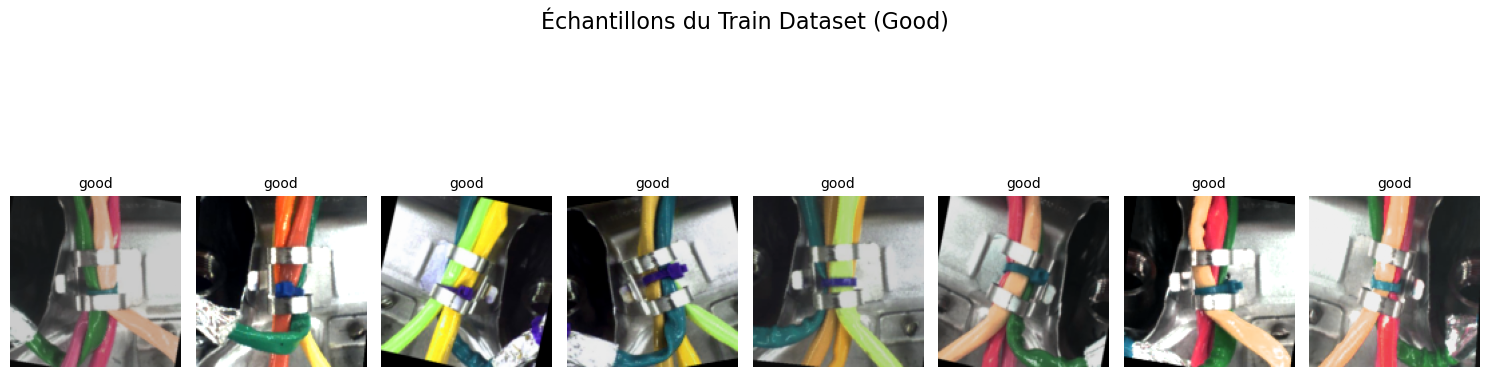

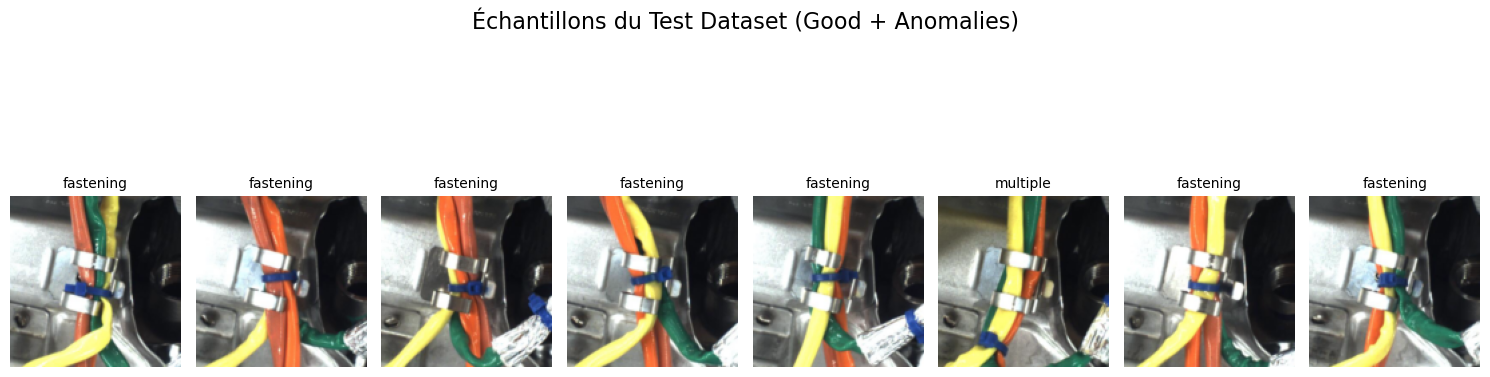

In [84]:

def plot_samples(dataset, title, n_samples=8):
    """
    Affiche des échantillons d'images du dataset avec leurs labels.

    Args:
        dataset (torch.utils.data.Dataset): Dataset à visualiser.
        title (str): Titre global du graphique.
        n_samples (int): Nombre d'échantillons à afficher.
    """
    # Sélection d'échantillons aléatoires
    indices = torch.randint(0, len(dataset), (n_samples,))
    samples = [dataset[i] for i in indices]
    images, labels = zip(*samples)
    
    # Création de la grille d'images
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0).numpy()  # Convertir Tensor en numpy
        img = (img * 0.5) + 0.5  # Inverser la normalisation
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(dataset.classes[label], fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Exemple d'utilisation
# Affiche des échantillons du train_loader et test_loader
plot_samples(autovi_train_dataset, "Échantillons du Train Dataset (Good)", n_samples=8)
plot_samples(autovi_test_dataset, "Échantillons du Test Dataset (Good + Anomalies)", n_samples=8)


# 2. Mise en place de plusieurs modèles SSL

In [68]:
# Initialisation des paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_ssl_model(model, 
                    train_loader, 
                    test_loader, 
                    criterion,
                    optimizer,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    epochs=15):
    """
    Entraîne un modèle SSL et retourne les pertes d'entraînement et de validation.
    
    Args:
        model (nn.Module): Modèle à entraîner.
        train_loader (DataLoader): DataLoader pour le dataset d'entraînement.
        test_loader (DataLoader): DataLoader pour le dataset de test.
        criterion: Fonction de perte.
        optimizer: Optimiseur.
        device: GPU ou CPU.
        epochs (int): Nombre d'époques.
        
    Returns:
        Tuple[List[float], List[float]]: Listes des pertes d'entraînement et de validation.
    """
    train_losses = []
    val_losses = []
    
    model.to(device)
    for epoch in range(epochs):
        # Entraînement
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                loss = criterion(output, images)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    return model.encoder, train_losses, val_losses


In [69]:


# Visualize colorization on random test images

def visualize_reconstructions(model, data_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Convert the DataLoader to a list to randomly sample images
    dataset = list(data_loader.dataset)

    # Randomly select `num_images` images from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    random_images = [dataset[i][0] for i in random_indices]  # Extract only the images, ignoring labels

    # Stack the images into a batch
    images = torch.stack(random_images)

    # Move images to the specified device
    images = images.to(device)
    
    # Run the grayscale images through the colorization model
    with torch.no_grad():
        reconstructed_images, perturbed_images = model(images)
    
    # Move images back to CPU for visualization
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()
    perturbed_images = perturbed_images.cpu()
    
    # Plot the grayscale, ground truth, and colorized images
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 4))
    for i in range(num_images):
        # Grayscale input
        axes[i, 0].imshow(perturbed_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title("Grayscale Input")
        axes[i, 0].axis('off')
        
        # Ground truth (original RGB image)
        axes[i, 1].imshow(images[i].permute(1, 2, 0))
        axes[i, 1].set_title("Ground Truth (RGB)")
        axes[i, 1].axis('off')
        
        # Colorized output from the model
        axes[i, 2].imshow(reconstructed_images[i].permute(1, 2, 0))
        axes[i, 2].set_title("Colorized Output")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [70]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

## (a) Autoencodeur masqué

In [71]:
class MaskedAutoencoderModel(nn.Module):
    def __init__(self, latent_dim=128, mask_ratio=1/16):
        super(MaskedAutoencoderModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_ratio = mask_ratio

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        x_masked = x.clone()
        mask = torch.rand_like(x[:, 0, :, :]) < self.mask_ratio
        mask = mask.unsqueeze(1).repeat(1, x.size(1), 1, 1)
        x_masked[mask] = 0
        return x_masked


Epoch 1/5, Train Loss: 0.4175, Val Loss: 0.4046
Epoch 2/5, Train Loss: 0.3992, Val Loss: 0.4046
Epoch 3/5, Train Loss: 0.3995, Val Loss: 0.4046
Epoch 4/5, Train Loss: 0.3986, Val Loss: 0.4046
Epoch 5/5, Train Loss: 0.3987, Val Loss: 0.4046


ValueError: x and y must have same first dimension, but have shapes (15,) and (5,)

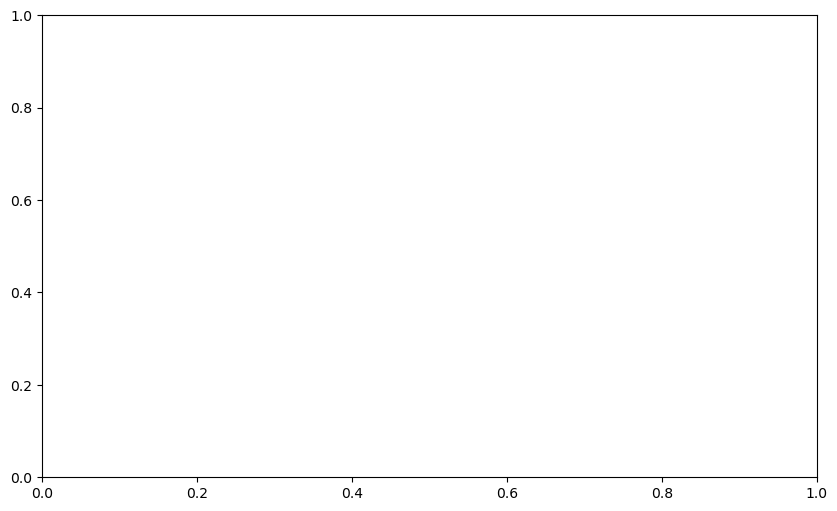

In [86]:
epoch = 15

# Entraîner le modèle et récupérer les pertes
mae_encoder, train_losses, val_losses = train_ssl_model(
    mae_model,
    autovi_train_loader, 
    filtered_test_loader, 
    criterion=nn.MSELoss(), 
    optimizer=optim.Adam(mae_model.parameters(), lr=0.001),
    epochs=epoch
)

# Tracer les courbes de perte
epochs_range = range(1, epcoh + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Perte d\'entraînement', marker='o')
plt.plot(epochs_range, val_losses, label='Perte de validation', marker='o')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.title('Courbes d\'entraînement et de validation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

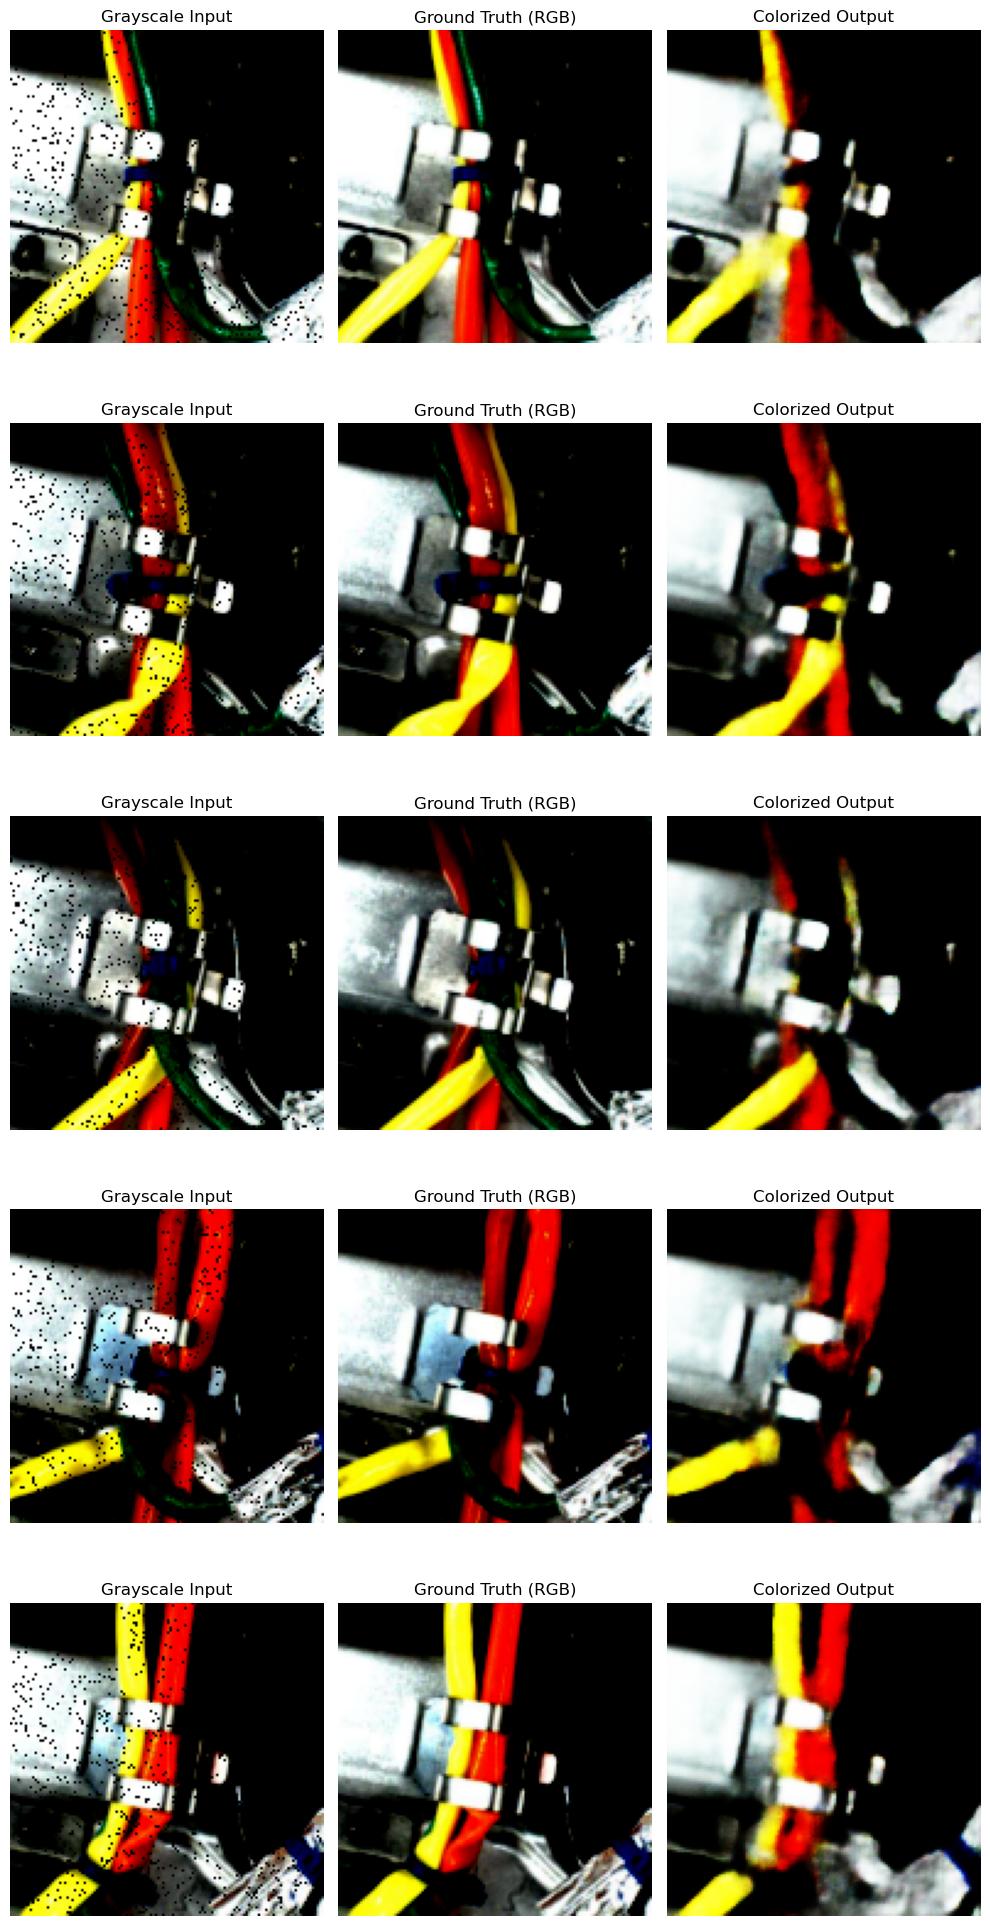

In [74]:
# Exemple d'utilisation
visualize_reconstructions(mae_model, autovi_test_loader, device, num_images=5)


## (b) Modèle colorization

In [37]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x


In [39]:
colorization_model = ColorizationModel(latent_dim=128)
colorization_encoder = train_ssl_model(colorization_model,
                              autovi_train_loader, 
                              autovi_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(mae_model.parameters(), lr=0.001),
                              epochs=15
                              )

Epoch 1/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 2/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 3/15, Train Loss: 0.7184, Avg Val Loss: 0.7346
Epoch 4/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 5/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 6/15, Train Loss: 0.7182, Avg Val Loss: 0.7346
Epoch 7/15, Train Loss: 0.7182, Avg Val Loss: 0.7346
Epoch 8/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 9/15, Train Loss: 0.7182, Avg Val Loss: 0.7346
Epoch 10/15, Train Loss: 0.7182, Avg Val Loss: 0.7346
Epoch 11/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 12/15, Train Loss: 0.7181, Avg Val Loss: 0.7346
Epoch 13/15, Train Loss: 0.7183, Avg Val Loss: 0.7346
Epoch 14/15, Train Loss: 0.7179, Avg Val Loss: 0.7346
Epoch 15/15, Train Loss: 0.7183, Avg Val Loss: 0.7346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


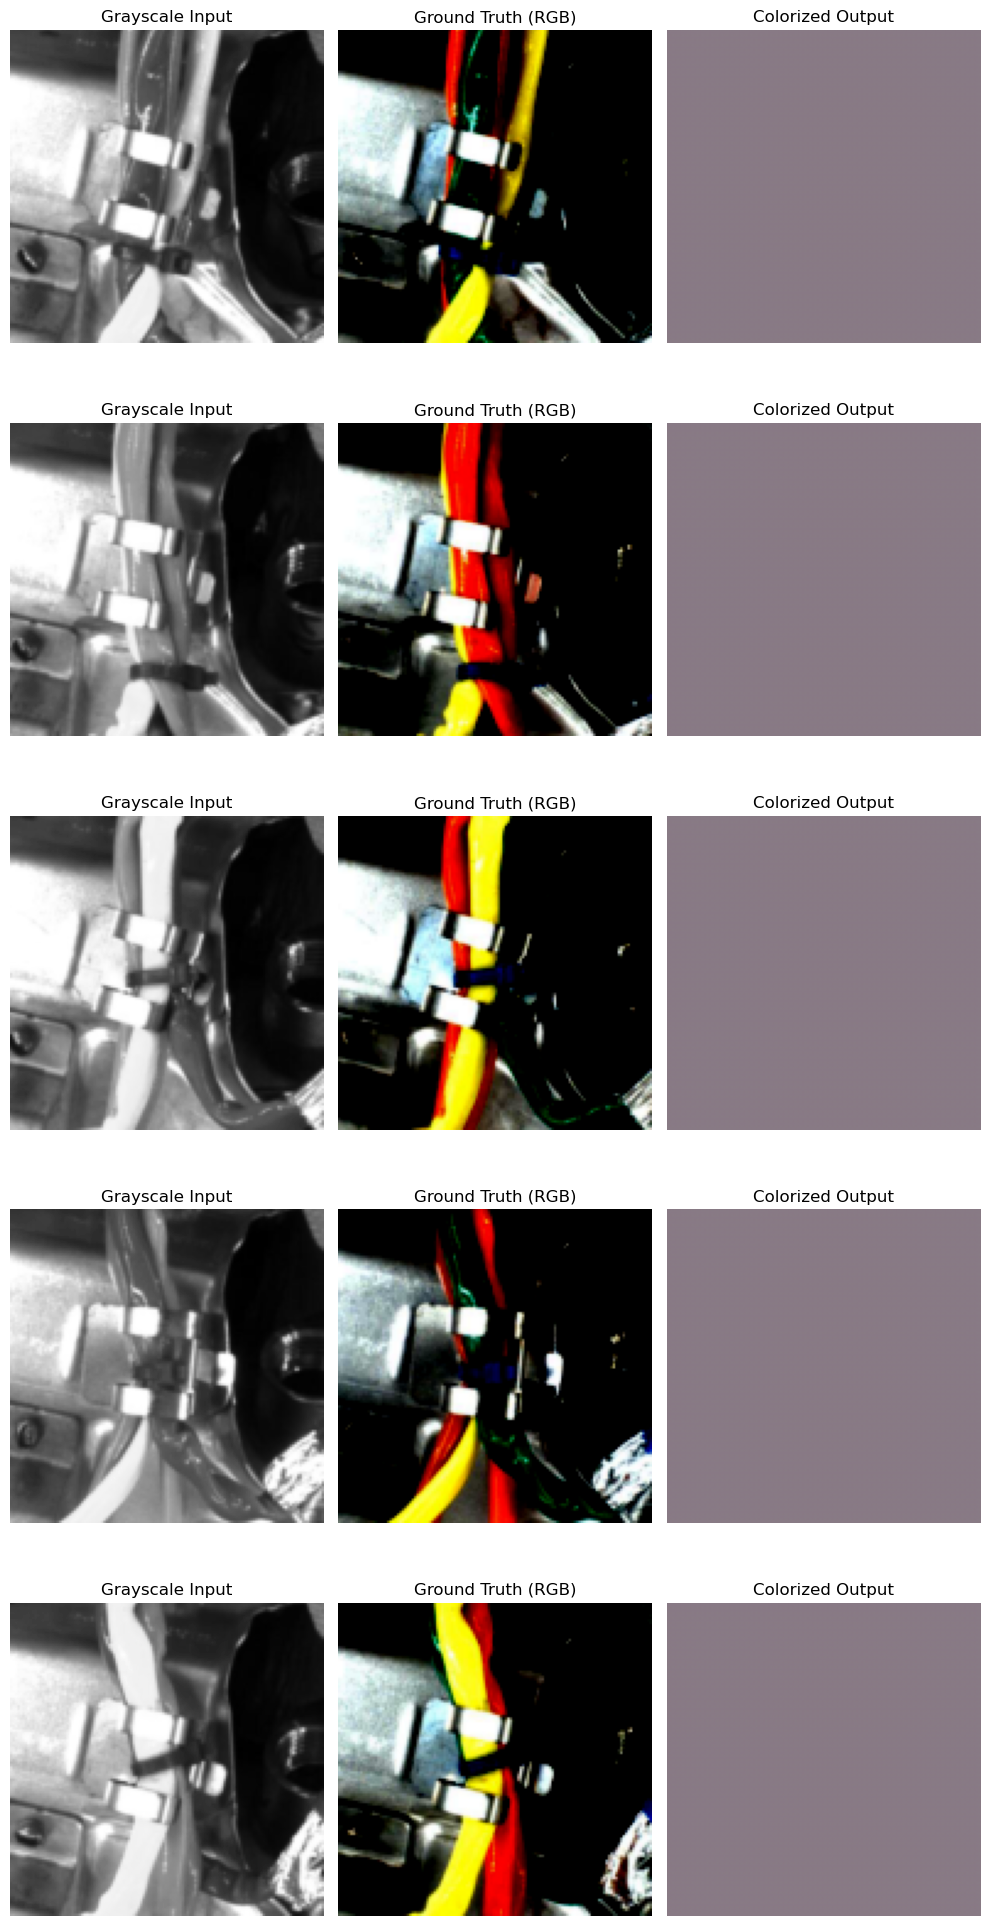

In [40]:
visualize_reconstructions(colorization_model, autovi_test_loader, device, num_images=5)


## (c) Modèle d’inpainting

In [45]:
class InpaintingModel(nn.Module):
    def __init__(self, latent_dim=128, mask_size=8):
        super(InpaintingModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.mask_size = mask_size

    def forward(self, x):
        x_masked = self.apply_mask(x)
        z = self.encoder(x_masked)
        return self.decoder(z), x_masked
    
    def apply_mask(self, x):
        masked_x = x.clone()

        for i in range(masked_x.size(0)):
            ul_x = np.random.randint(0, x.size(2) - self.mask_size + 1)
            ul_y = np.random.randint(0, x.size(3) - self.mask_size + 1)
            masked_x[i, :, ul_x:ul_x+self.mask_size, ul_y:ul_y+self.mask_size] = 0

        return masked_x


In [46]:
Inpainting_Model = InpaintingModel(latent_dim=128)
Inpainting_encoder = train_ssl_model(Inpainting_Model,
                              autovi_train_loader, 
                              autovi_test_loader, 
                              criterion=nn.MSELoss(), 
                              optimizer=optim.Adam(mae_model.parameters(), lr=0.001),
                              epochs=15
                                    )
                              

Epoch 1/15, Train Loss: 0.7111, Avg Val Loss: 0.7274
Epoch 2/15, Train Loss: 0.7108, Avg Val Loss: 0.7274
Epoch 3/15, Train Loss: 0.7110, Avg Val Loss: 0.7274
Epoch 4/15, Train Loss: 0.7108, Avg Val Loss: 0.7274
Epoch 5/15, Train Loss: 0.7110, Avg Val Loss: 0.7274
Epoch 6/15, Train Loss: 0.7109, Avg Val Loss: 0.7274
Epoch 7/15, Train Loss: 0.7112, Avg Val Loss: 0.7274
Epoch 8/15, Train Loss: 0.7110, Avg Val Loss: 0.7274
Epoch 9/15, Train Loss: 0.7109, Avg Val Loss: 0.7274
Epoch 10/15, Train Loss: 0.7111, Avg Val Loss: 0.7274
Epoch 11/15, Train Loss: 0.7112, Avg Val Loss: 0.7274
Epoch 12/15, Train Loss: 0.7111, Avg Val Loss: 0.7274
Epoch 13/15, Train Loss: 0.7112, Avg Val Loss: 0.7274
Epoch 14/15, Train Loss: 0.7112, Avg Val Loss: 0.7274
Epoch 15/15, Train Loss: 0.7109, Avg Val Loss: 0.7274


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

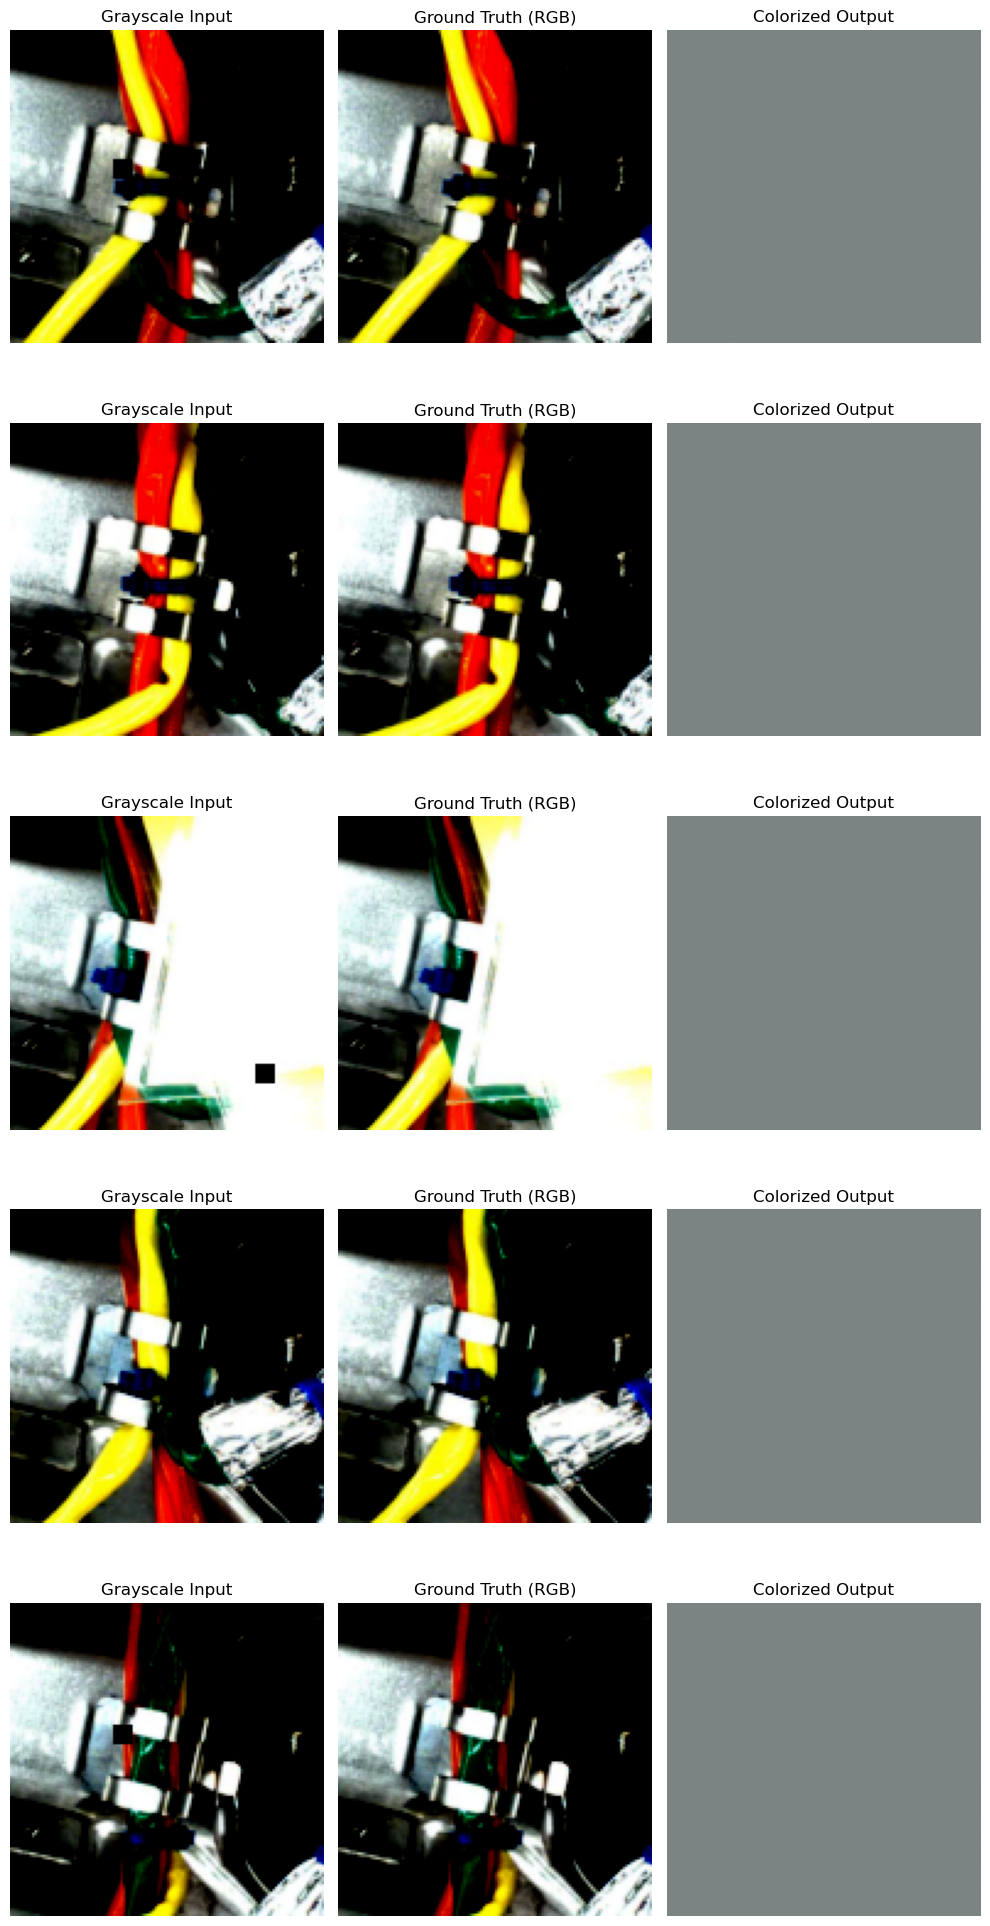

In [47]:
visualize_reconstructions(Inpainting_Model, autovi_test_loader, device, num_images=5)

# 4. Évaluation des performances avec les métriques AUROC et courbes ROC

In [ ]:
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images).item()
            y_scores.append(loss)
            y_true.extend(labels.cpu().numpy())

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.title("ROC Curve")
    plt.show()
